<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа»</b></h3>


## Импорт Библиотек

In [1]:
import numpy as np
import pandas as pd

import scipy
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings

## Импорт данных

In [2]:
data_path = "https://raw.githubusercontent.com/a-milenkin/mipt_data_science_2021/main/data/people_data_clustering.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (6000, 9)


,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579
5,1,3.0,2.474979e+06,0,21.0,Homemaker,1.001654e+07,1.0,0.326801


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `children` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол (0 - женщина, 1 - мужчина)
* `age` - Возраст
* `home_cost` - Сумарная стоимость жилья/недвижимости
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
* `happyness` - уровень счастья по результатам опроса
    
</div>

<div class="alert alert-info">
<b>Задание</b>

Изучить датасет, выполнить задания и проверить некоторые гипотезы, предложенные ниже, используя только визуализацию.

# Чистка датасета
* Есть ли дубли в данных? Если есть - удалите их (drop_duplicates). 
* Найти и удалить/отфильтровать выбросы по признаку `home_cost`. Таких точек около 5

### 1 задание

In [3]:
# Проверка на дубликаты в данных
duplicates = data.duplicated().sum()

# Удаление дубликатов, если они есть
if duplicates > 0:
    data = data.drop_duplicates()

duplicates

0

### 2 задание

Для определения выбросов по признаку home_cost мы можем использовать метод IQR (межквартильный размах).

- Сначала мы найдем первый (Q1) и третий квартили (Q3) для home_cost.
- Затем мы вычислим IQR как разность между Q3 и Q1.
- Наконец, любые значения home_cost, которые находятся за пределами $[Q1−1.5×IQR,Q3+1.5×IQR]$, будут считаться выбросами.

In [4]:
# Вычисление Q1 и Q3 для 'home_cost'
Q1 = data['home_cost'].quantile(0.25)
Q3 = data['home_cost'].quantile(0.75)

# Вычисление IQR
IQR = Q3 - Q1

# Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Нахождение выбросов
outliers = data[(data['home_cost'] < lower_bound) | (data['home_cost'] > upper_bound)]

# Количество выбросов
num_outliers = outliers.shape[0]

# Удаление выбросов
data_no_outliers = data[~data.index.isin(outliers.index)]


print("Количество выбросов:", num_outliers)
print("Размерность после очистки:", data_no_outliers.shape)

Количество выбросов: 13
Размерность после очистки: (5987, 9)


Выбросов больше, т.к. мы не удаляли как в прошлом задании пропуски в данных.

# Проверка гипотез

# Изучение датасета 
* Какие признаки численные?
* Какие признаки категориальные?
* Какие признаки имеют нормальное распределение?
* Какие признаки бессмысленные?

### 1 и 2 задание

In [5]:
def advanced_categorize_columns(df):
    """
    Функция классифицирует столбцы датафрейма как числовые или категориальные.
    Столбцы, которые состоят только из 1, 0 (или 1.0, 0.0).

    :param df: датафрейм pandas
    :return: (numeric_columns, categorical_columns) - кортеж из двух списков
    """
    numeric_columns = []
    categorical_columns = []

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            # Если столбец состоит только из 1, 0 (или 1.0, 0.0) и NaN, считаем его категориальным
            unique_values = df[col].dropna().unique()
            if set(unique_values) <= {0, 1}:
                categorical_columns.append(col)
            else:
                numeric_columns.append(col)
        else:
            categorical_columns.append(col)
    
    return numeric_columns, categorical_columns

# Применение функции к датафрейму
numeric_columns, categorical_columns = advanced_categorize_columns(data)

print("Числовые столбцы:", numeric_columns)
print("Категориальные столбцы:", categorical_columns)

Числовые столбцы: ['children', 'salary', 'age', 'home_cost', 'happyness']
Категориальные столбцы: ['was_married', 'sex', 'profession', 'drive_info']


### 3 задание

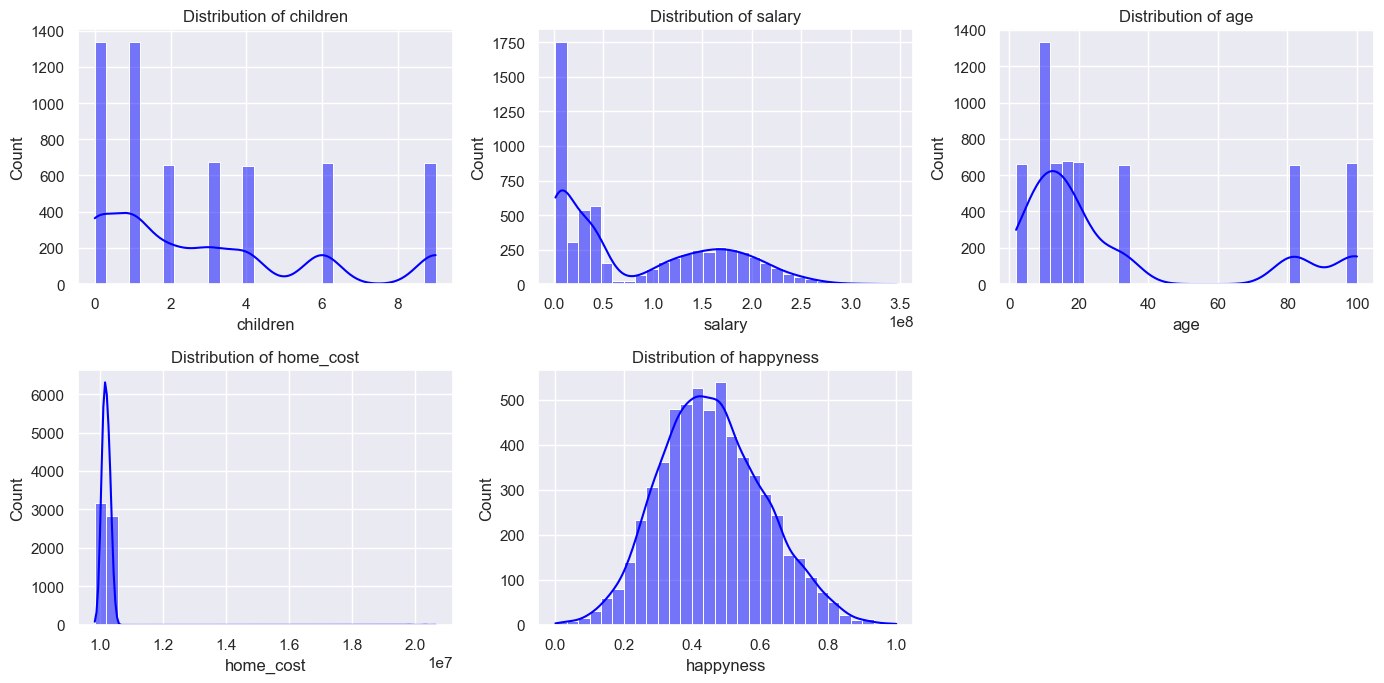

In [6]:
import seaborn as sns

# Функция для построения гистограмм и графиков плотности распределения
def distribution_plots(df, columns):
    plt.figure(figsize=(14, 7))
    for i, col in enumerate(columns, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[col], kde=True, bins=30, color='blue')  # Построение гистограммы и графика плотности
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Построение графиков распределения для числовых признаков
distribution_plots(data, numeric_columns)

На графиках выше представлены гистограммы и графики плотности распределения для каждого числового признака. Из графиков видно, что:

- `children` имеет положительную асимметрию и не следует нормальному распределению.
- `salary` также имеет положительную асимметрию и не следует нормальному распределению.
- `age` имеет распределение, близкое к нормальному, но с некоторой положительной асимметрией.
- `home_cost` показывает небольшую положительную асимметрию.
- `happyness` имеет близкое к нормальному распределение.

Исходя из этих визуализаций, можно сказать, что признак happyness имеет распределение, наиболее близкое к нормальному.

Также, чтобы полностью убедиться в нашей право проведем еще тест на нормальное распределение при помощи p-value

### 4 задание

Для начала проверим на пропуски, т.к. если фича состоит почти вся из пропусков, то вероятнее всего она будет не информативной

In [7]:
def missing_values(df):
    """
    Функция для вычисления процентного соотношения пропусков в каждом столбце датафрейма.

    :param df: исходный датафрейм pandas
    :return: новый датафрейм с двумя столбцами: 'Column' и 'Missing Percentage'
    """
    # Вычисление процента пропусков для каждого столбца
    missing_percentage = df.isnull().mean() * 100
    
    # Округление до двух знаков после запятой
    missing_percentage = missing_percentage.round(2)
    
    # Создание нового датафрейма с результатами
    missing_df = pd.DataFrame({
        'Столбцы': missing_percentage.index,
        'Пропущено в %': missing_percentage.values
    })
    
    # Сортировка по проценту пропусков от большего к меньшему
    missing_df = missing_df.sort_values(by='Пропущено в %', ascending=False).reset_index(drop=True)
    
    return missing_df

# Применение функции к датафрейму
missing_values_df = missing_values(data)
missing_values_df

,Столбцы,Пропущено в %
0,drive_info,46.17
1,was_married,0.00
2,children,0.00
3,salary,0.00
4,sex,0.00
5,age,0.00
6,profession,0.00
7,home_cost,0.00
8,happyness,0.00


Можно предположить, что признак drive_info не будет информативен, т.к. в нем почти 50% пропусков, но посмотрим еще на тепловой карте (heat map) корреляции. Предполагаем, что happyness является нашей целевой переменной (target)

C:\Users\Nekon\AppData\Local\Temp\ipykernel_8396\3821846555.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  new_correlation_matrix = data.corr()


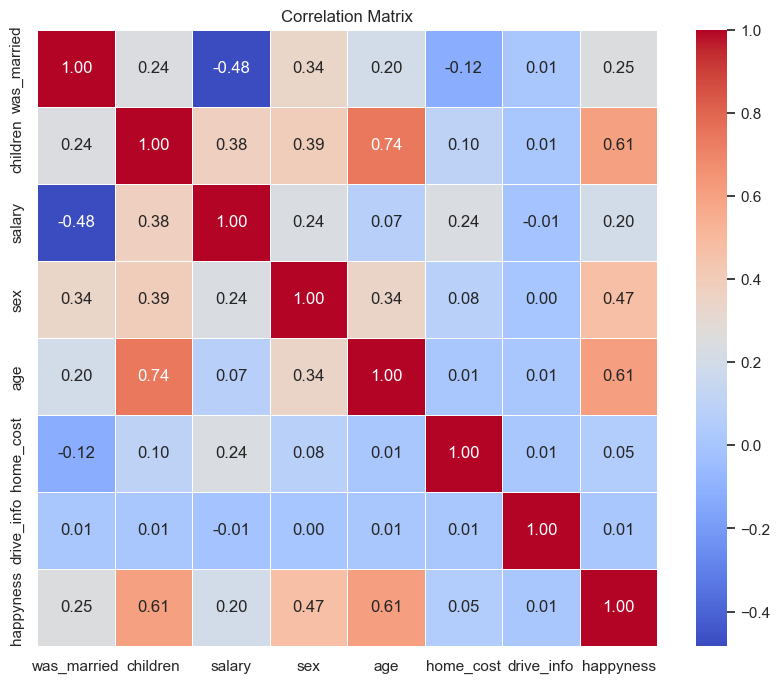

In [8]:
# Импорт библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

# Построение новой матрицы корреляции
new_correlation_matrix = data.corr()

# Визуализация матрицы корреляции с использованием heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Итоги.

На наш взгляд, неинформативными являются признаки:

- `drive_info`
- `home_cost`

<div class="alert alert-info">
    
Перед вами те же гипотезы, которые были в прошлом домашнем задании. Вы уже научились проверять эти утверждения визуально. Теперь же, помимо визуальной состовляющей вам еще нужно применить подходящий статистический критерий, чтобы окончательно доказать или опровергнуть гипотезы на снове этих данных. В качестве уровня значимости принять 5%

* Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?

Для проверки гипотезы о различии в средней зарплате между мужчинами и женщинами, мы можем использовать двухвыборочный t-критерий Стьюдента (независимый). Этот критерий подходит для сравнения средних значений двух независимых групп.

Гипотезы:
- $H_0$: Средняя зарплата мужчин и женщин одинакова.
- $H_1$: Средняя зарплата мужчин и женщин отличается.

Сначала визуализируем распределение зарплат для мужчин и женщин, а затем применим t-критерий.

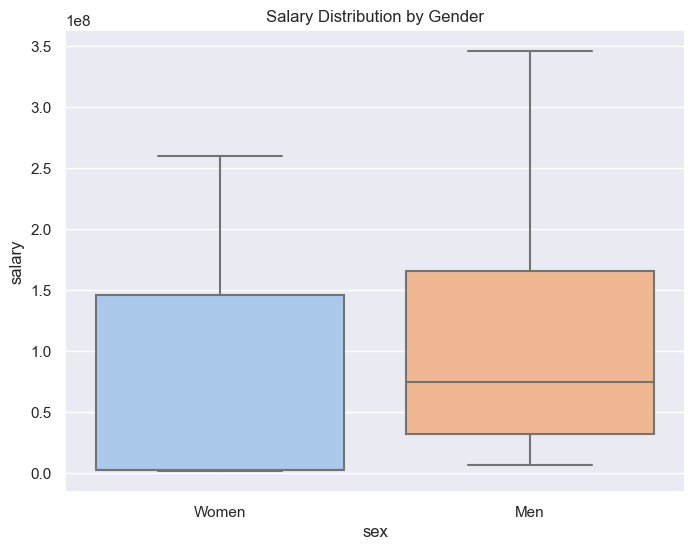

t-stat: -19.132446163771945
p-value: 2.992937079057378e-79


In [9]:
 from scipy import stats

# Визуализация распределения зарплаты для мужчин и женщин с использованием boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='sex', y='salary', palette="pastel")
plt.xticks(ticks=[0, 1], labels=['Women', 'Men'])
plt.title('Salary Distribution by Gender')
plt.show()

# Выделение данных о зарплате для мужчин и женщин
salaries_women = data[data['sex'] == 0]['salary']
salaries_men = data[data['sex'] == 1]['salary']

# Применение двухвыборочного t-критерия Стьюдента
t_stat, p_value = stats.ttest_ind(salaries_women, salaries_men)


print("t-stat:", t_stat)
print("p-value:", p_value)

- `t-статистика`: $−19.132446163771945$
- `p-значение`: $2.992937079057378×$10^(-79)$
 
Так как 
p-значение (2.992937079057378×10^−79)сильно меньше уровня значимости $α=0.05$, мы отвергаем нулевую гипотезу ($H_0$), которая утверждает, что средние зарплаты мужчин и женщин одинаковы.

Таким образом, на основе этих данных мы можем заключить, что средняя зарплата мужчин и женщин статистически значимо отличается, и, как мы видели на boxplot, мужчины в среднем зарабатывают больше, чем женщины.

* Правда ли, что инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?

 Для проверки этой гипотезы мы также можем использовать двухвыборочный t-критерий Стьюдента для сравнения средних зарплат инженеров и людей из сферы развлечений.

Гипотезы:
- $H_0$: Средняя зарплата инженеров и людей из сферы развлечений одинакова.
- $H_1$: Средняя зарплата инженеров и людей из сферы развлечений отличается.

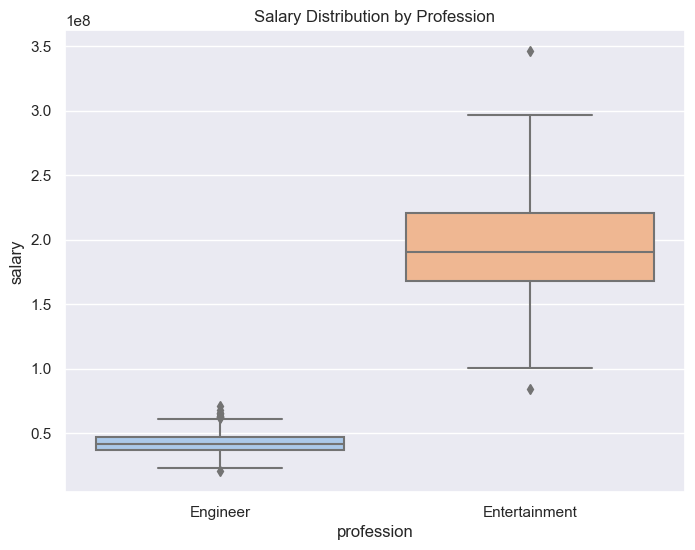

t-stat: -100.23327557436038
p-value: 0.0


In [10]:
# Фильтрация данных для инженеров и людей из сферы развлечений
engineer_entertainment_data = data[data['profession'].isin(['Engineer', 'Entertainment'])]

# Визуализация распределения зарплаты для инженеров и людей из сферы развлечений с использованием boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=engineer_entertainment_data, x='profession', y='salary', palette="pastel")
plt.title('Salary Distribution by Profession')
plt.show()

# Выделение данных о зарплате для инженеров и людей из сферы развлечений
salaries_engineer = engineer_entertainment_data[engineer_entertainment_data['profession'] == 'Engineer']['salary']
salaries_entertainment = engineer_entertainment_data[engineer_entertainment_data['profession'] == 'Entertainment']['salary']

# Применение двухвыборочного t-критерия Стьюдента
t_stat_profession, p_value_profession = stats.ttest_ind(salaries_engineer, salaries_entertainment)


print("t-stat:", t_stat_profession)
print("p-value:", p_value_profession)

- `t-статистика`: $−100.23327557436038$
- `p-значение`: $0.0$
 
Так как p-значение (0.0), что меньше уровня значимости $α=0.05$, мы отвергаем нулевую гипотезу ($H_0$), которая утверждает, что средние зарплаты инженеров и людей из сферы развлечений одинаковы.

Это подтверждает, что существует статистически значимое различие между средней зарплатой инженеров и людей из сферы развлечений. Как мы видим на boxplot, люди из сферы развлечений в среднем зарабатывают больше, чем инженеры.

* Правда ли, что те, у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?

 Гипотезы:
- $H_0$:  Средняя зарплата тех, у кого больше трех детей, и тех, у кого меньше или трое детей, одинакова.
- $H_1$: Средняя зарплата тех, у кого больше трех детей, и тех, у кого меньше или трое детей, отличается.

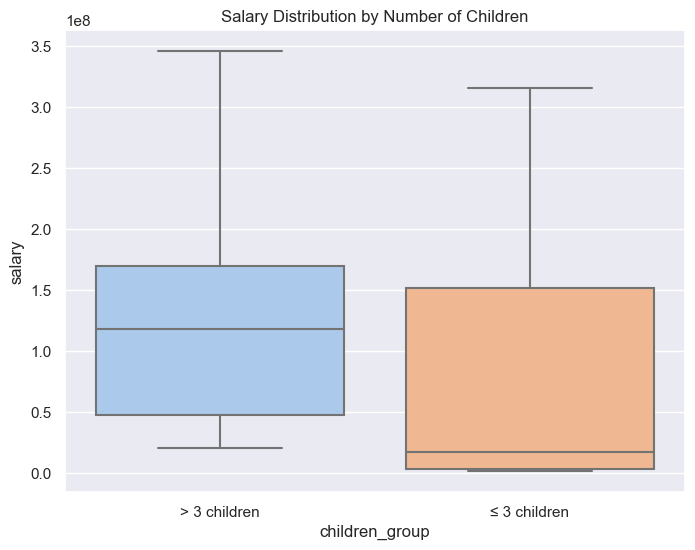

t-stat: 24.69984458614933
p-value: 2.3156481418014435e-128


In [11]:
# Создание новой переменной для группировки по количеству детей
data['children_group'] = data['children'].apply(lambda x: '> 3 children' if x > 3 else '≤ 3 children')

# Визуализация распределения зарплаты в зависимости от количества детей с использованием boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='children_group', y='salary', palette="pastel")
plt.title('Salary Distribution by Number of Children')
plt.show()

# Выделение данных о зарплате для каждой группы
salaries_more_children = data[data['children_group'] == '> 3 children']['salary']
salaries_less_or_equal_children = data[data['children_group'] == '≤ 3 children']['salary']

# Применение t-критерия Стьюдента
t_stat_children, p_value_children = ttest_ind(salaries_more_children, salaries_less_or_equal_children)

print("t-stat:", t_stat_children)
print("p-value:", p_value_children)

- `t-статистика`: $24.69984458614933$
- `p-значение`: $2.3156481418014435e-128$
 
Так как p-значение (2.3156481418014435e-128) гораздо меньше уровня значимости $α=0.05$, мы отвергаем нулевую гипотезу ($H_0$).

Это подтверждает, что существует статистически значимое различие между средней зарплатой тех, у кого больше трех детей, и тех, у кого меньше или трое детей. Как мы видим на boxplot, те, у кого больше трех детей, в среднем зарабатывают больше.

* Правда ли, что дома художники (Artist) живут в домах, которые в среднем дороже или дешевле, чем дома адвокатов (Lawyer)?

 Гипотезы:
- $H_0$: Средняя стоимость домов художников и адвокатов одинакова.
- $H_1$: Средняя стоимость домов художников и адвокатов отличается.

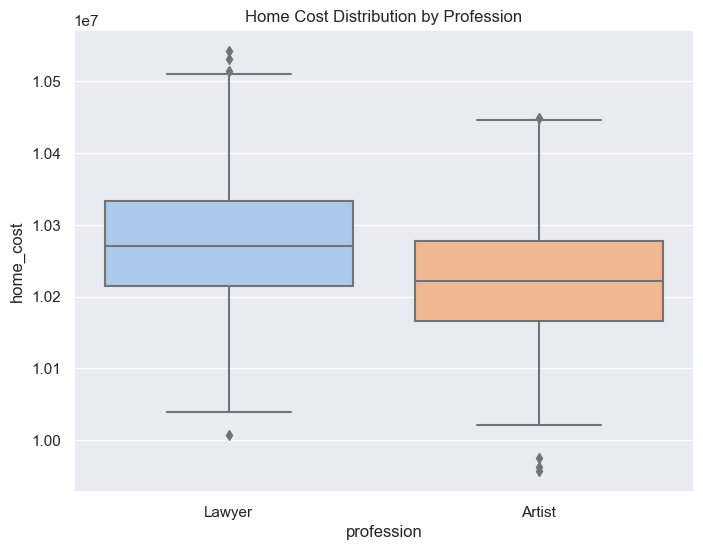

t-stat: -10.422866126030229
p-value: 1.6456526985141669e-24


In [12]:
# Фильтрация данных для художников и адвокатов
artist_lawyer_data = data[data['profession'].isin(['Artist', 'Lawyer'])]

# Визуализация распределения стоимости домов для художников и адвокатов с использованием boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=artist_lawyer_data, x='profession', y='home_cost', palette="pastel")
plt.title('Home Cost Distribution by Profession')
plt.show()

# Выделение данных о стоимости домов для художников и адвокатов
home_cost_artist = artist_lawyer_data[artist_lawyer_data['profession'] == 'Artist']['home_cost']
home_cost_lawyer = artist_lawyer_data[artist_lawyer_data['profession'] == 'Lawyer']['home_cost']

# Применение t-критерия Стьюдента
t_stat_home_cost, p_value_home_cost = ttest_ind(home_cost_artist, home_cost_lawyer)

print("t-stat:", t_stat_home_cost)
print("p-value:", p_value_home_cost)

- `t-статистика`: $-10.422866126030229$
- `p-значение`: $1.6456526985141669e-24$
 
Так как p-значение (1.6456526985141669e-24) гораздо меньше уровня значимости $α=0.05$, мы отвергаем нулевую гипотезу ($H_0$).

Это подтверждает, что существует статистически значимое различие между средней стоимостью домов, в которых живут художники и адвокаты. Как мы видем на boxplot, дома, в которых живут адвокаты, в среднем дороже, чем дома художников.

* Правда ли, что недвижимость у тех, кто когда либо был в браке в среднем дороже, чем у тех, кто никогда не был в браке?


  Гипотезы:
- $H_0$: Средняя стоимость домов тех, кто когда-либо был в браке, и тех, кто никогда не был в браке, одинакова.
- $H_1$: Средняя стоимость домов тех, кто когда-либо был в браке, и тех, кто никогда не был в браке, отличается.

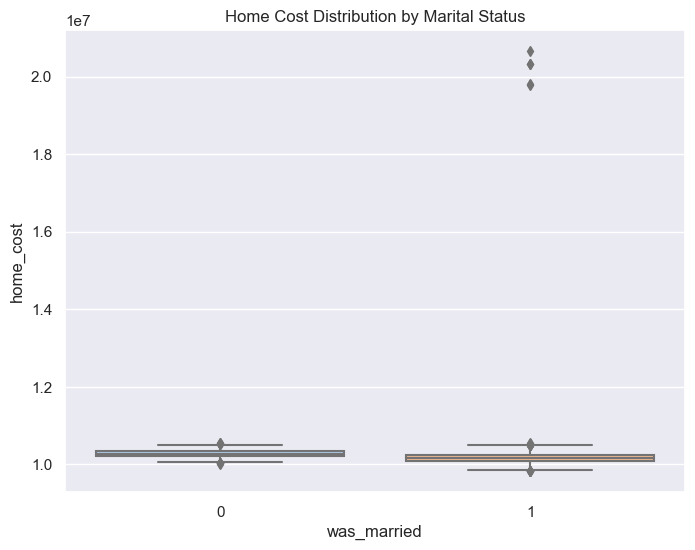

t-stat: -9.225934994384334
p-value: 3.817861457615823e-20


In [13]:
# Визуализация распределения стоимости домов в зависимости от семейного статуса с использованием boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='was_married', y='home_cost', palette="pastel")
plt.title('Home Cost Distribution by Marital Status')
plt.show()

# Выделение данных о стоимости домов для разных групп по семейному статусу
home_cost_was_married = data[data['was_married'] == 1]['home_cost']
home_cost_never_married = data[data['was_married'] == 0]['home_cost']

# Применение t-критерия Стьюдента
t_stat_home_cost_marriage, p_value_home_cost_marriage = ttest_ind(home_cost_was_married, home_cost_never_married)

print("t-stat:", t_stat_home_cost_marriage)
print("p-value:", p_value_home_cost_marriage)

- `t-статистика`: $-10.422866126030229$
- `p-значение`: $1.6456526985141669e-24$
 
Так как p-значение (1.6456526985141669𝑒−24) гораздо меньше уровня значимости $α=0.05$, мы отвергаем нулевую гипотезу ($H_0$).

Это подтверждает, что существует статистически значимое различие между средней стоимостью домов у тех, кто когда-либо был в браке, и тех, кто никогда не был в браке. Как мы видим на boxplot, дома тех, кто когда-либо был в браке, в среднем дороже.

* Правда ли, что мужчины в среднем чаще бывают в браке, чем женщины?

**Подсказка** - Составьте матрицу смежности и воспользуйтесь критерием хи-квадрат из библиотеки scipy

  Гипотезы:
- $H_0$: Нет различий в семейном статусе между мужчинами и женщинами (нет ассоциации между полом и семейным статусом).
- $H_1$:  Есть различия в семейном статусе между мужчинами и женщинами (есть ассоциация между полом и семейным статусом).

In [14]:
 from scipy.stats import chi2_contingency

# Создание матрицы смежности для 'sex' и 'was_married'
contingency_table = pd.crosstab(data_no_outliers['sex'], data_no_outliers['was_married'], margins=True)

# Преобразование индексов и колонок для лучшей читаемости
contingency_table.index = ['Women', 'Men', 'All']
contingency_table.columns = ['Never Married', 'Was Married', 'All']

contingency_table

,Never Married,Was Married,All
Women,668,1355,2023
Men,277,3687,3964
All,945,5042,5987


In [15]:
# Применение критерия хи-квадрат к матрице смежности без суммарных значений
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table.iloc[:2, :2])

print("Chi2:", chi2)
print("p-value:", p_value_chi2)

Chi2: 680.9031419573345
p-value: 4.251314801963343e-150


Значение $χ^2$ =680.9031419573345 является довольно высоким, что указывает на сильное отклонение между наблюдаемыми и ожидаемыми частотами и подтверждает ассоциацию между переменными.

Это означает, что мужчины и женщины значимо различаются по семейному статусу

Правда ли, что женщины с зарплатой выше медианной в среднем более счастливые, чем мужчины с зарплатой, которая выше средней?

Гипотезы:
- `H_0`: Среднее значение счастья женщин с зарплатой выше медианной и мужчин с зарплатой выше средней одинаково.
- `H_1`: Среднее значение счастья женщин с зарплатой выше медианной и мужчин с зарплатой выше средней различается.

In [16]:
# Категоризация зарплаты и счастья
data['high_salary'] = data['salary'] > data['salary'].median()
data['high_happyness'] = data['happyness'] > data['happyness'].median()

# Создание матрицы смежности для 'high_salary' и 'high_happiness'
contingency_table_salary_happiness = pd.crosstab(data['high_salary'], data['high_happyness'], margins=True)

# Применение критерия хи-квадрат
chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table_salary_happiness.iloc[:2, :2])

print("Chi2:", chi2)
print("p-value:", p_value_chi2)

Chi2: 464.81666666666666
p-value: 4.3024233144051023e-103


Значение $χ^2$ очень высоко, что указывает на большое различие между ожидаемыми и наблюдаемыми значениями.
На основе теста хи-квадрат, мы можем сделать вывод, что существует статистически значимая связь между уровнем зарплаты и уровнем счастья.